# Análise de Resposta em Frequência (Ball & Beam)

Este notebook processa dados experimentais para identificar a resposta em frequência do sistema.

**Instruções:**
1. Execute a célula de **Configuração e Bibliotecas**.
2. Faça o **Upload** do seu arquivo `.csv` na célula seguinte.
3. Escolha qual análise deseja rodar:
    * **Gerar Diagrama de Bode:** Varre todas as frequências e plota Magnitude e Fase.
    * **Visualizador Temporal:** Escolha um período específico para ver o ajuste da senoide (útil para depuração).

In [ ]:
# --- CONFIGURAÇÃO E BIBLIOTECAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# Configurações globais de plotagem
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-v0_8-whitegrid')


def encaixar_senoide(tempo, sinal, frequencia_hz):
    """
    Ajusta uma senoide y = A*sin(wt) + B*cos(wt) + C aos dados.
    Retorna: amplitude, fase (rad), r2 e o sinal reconstruído.
    """
    frequencia_angular = 2 * np.pi * frequencia_hz

    # Matriz de design: [sin(wt), cos(wt), 1]
    matriz_design = np.column_stack([
        np.sin(frequencia_angular * tempo),
        np.cos(frequencia_angular * tempo),
        np.ones_like(tempo)
    ])

    try:
        # Método dos Mínimos Quadrados
        coeficientes, _, _, _ = np.linalg.lstsq(matriz_design, sinal, rcond=None)
        A, B, offset = coeficientes
    except Exception:
        return 0, 0, 0, np.zeros_like(sinal)

    amplitude = np.sqrt(A**2 + B**2)
    fase_rad = np.arctan2(B, A)

    # Reconstrói o sinal ideal para cálculo do R² e visualização
    sinal_ajustado = A * np.sin(frequencia_angular * tempo) + B * np.cos(frequencia_angular * tempo) + offset

    # Cálculo do R²
    residuos = np.sum((sinal - sinal_ajustado) ** 2)
    total = np.sum((sinal - np.mean(sinal)) ** 2)
    r2 = 1 - (residuos / total) if total != 0 else 0.0

    return amplitude, fase_rad, r2, sinal_ajustado


def carregar_dataframe_upload(uploaded_files):
    """Processa o arquivo carregado pelo widget do Colab."""
    if not uploaded_files:
        print("Nenhum arquivo enviado.")
        return None

    nome_arquivo = next(iter(uploaded_files))
    print(f"Processando: {nome_arquivo}...")

    # Tenta diferentes encodings
    encodings = ['utf-8-sig', 'latin-1', 'cp1252']
    df = None

    for enc in encodings:
        try:
            # Lê direto da memória (io.BytesIO)
            df = pd.read_csv(io.BytesIO(uploaded_files[nome_arquivo]),
                           sep=';', decimal=',', encoding=enc)
            print(f"Sucesso! Encoding: {enc}")
            break
        except:
            continue

    if df is None:
        raise ValueError("Falha ao ler CSV. Verifique separador (;) e decimal (,).")

    # Padronização e Limpeza
    df.columns = [str(c).strip() for c in df.columns]
    colunas_obrigatorias = ['DataHora', 'Período', 'Setpoint', 'Posição']

    for col in colunas_obrigatorias:
        if col not in df.columns:
            raise KeyError(f"Coluna '{col}' não encontrada.")

    # Converte tempo
    df['DataHora'] = pd.to_datetime(df['DataHora'], format='%d/%m/%Y - %H:%M:%S,%f')
    df['Tempo_Segundos'] = (df['DataHora'] - df['DataHora'].iloc[0]).dt.total_seconds()

    return df


def gerar_bode(df):
    if df is None: return print("Erro: Nenhum dado carregado. Rode a célula de Upload.")

    resultados = []
    print(f"Analisando últimos {JANELA_ANALISE_S}s de cada frequência...\n")

    grupos = df.groupby('Período')

    for periodo, dados in grupos:
        if periodo <= 0: continue

        # Filtra janela temporal
        tempo_fim = dados['Tempo_Segundos'].max()
        dados_estaveis = dados[dados['Tempo_Segundos'] >= (tempo_fim - JANELA_ANALISE_S)]

        if len(dados_estaveis) < 10: continue

        freq_hz = 1.0 / periodo
        t = dados_estaveis['Tempo_Segundos'].values

        # Ajuste de Senoides
        amp_u, fase_u, r2_u, _ = encaixar_senoide(t, dados_estaveis['Setpoint'].values, freq_hz)
        amp_y, fase_y, r2_y, _ = encaixar_senoide(t, dados_estaveis['Posição'].values, freq_hz)

        if amp_u == 0: continue

        # Cálculo de Bode
        ganho_db = 20 * np.log10(amp_y / amp_u)
        defasagem = np.degrees(fase_y - fase_u)

        # Normaliza fase (-180 a +180)
        while defasagem > 180: defasagem -= 360
        while defasagem <= -180: defasagem += 360

        valido = (r2_y >= R2_MINIMO) and (amp_y >= AMPLITUDE_MINIMA)
        status = "[OK]" if valido else "[DESCARTADO]"

        print(f"{status} T={periodo}s ({freq_hz:.2f}Hz) | R²={r2_y:.2f} | Mag={ganho_db:.1f}dB | Fase={defasagem:.1f}°")

        resultados.append({
            'freq_hz': freq_hz, 'magnitude_db': ganho_db,
            'fase_graus': defasagem, 'aceito': valido
        })

    # --- PLOTAGEM ---
    if not resultados: return print("Nenhum resultado válido encontrado.")

    df_res = pd.DataFrame(resultados).sort_values('freq_hz')
    validos = df_res[df_res['aceito']]
    descartados = df_res[~df_res['aceito']]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Magnitude
    ax1.semilogx(validos['freq_hz'], validos['magnitude_db'], 'o-', label='Válidos')
    if not descartados.empty:
        ax1.semilogx(descartados['freq_hz'], descartados['magnitude_db'], 'x', color='red', alpha=0.5, label='Descartados')
    ax1.set_ylabel('Magnitude (dB)')
    ax1.set_title('Diagrama de Bode Experimental')
    ax1.grid(True, which="both", alpha=0.3)
    ax1.legend()

    # Fase
    ax2.semilogx(validos['freq_hz'], validos['fase_graus'], 'o-')
    if not descartados.empty:
        ax2.semilogx(descartados['freq_hz'], descartados['fase_graus'], 'x', color='red', alpha=0.5)
    ax2.set_ylabel('Fase (graus)')
    ax2.set_xlabel('Frequência (Hz)')
    ax2.grid(True, which="both", alpha=0.3)

    plt.tight_layout()
    plt.show()


def analisar_resposta_temporal(df):
    """
    Analisa a resposta temporal de um período específico, calculando
    ganho, defasagem e atraso, além de plotar o ajuste senoidal.
    """
    if df is None: return print("Erro: Nenhum dado carregado.")

    # Converte para float padrão do Python para exibir limpo
    periodos = sorted(df['Período'].unique())
    periodos_float = [float(p) for p in periodos]
    print(f"Períodos disponíveis (s): {periodos_float}")

    try:
        entrada = input("Digite o período para visualizar (ex: 10): ")
        periodo_alvo = float(entrada.replace(',', '.'))
    except ValueError:
        return print("Entrada inválida.")

    # Filtra dados
    grupo = df[df['Período'] == periodo_alvo]
    if grupo.empty: return print("Período não encontrado.")

    # Recorta janela final (últimos 30s)
    tempo_fim = grupo['Tempo_Segundos'].max()
    dados = grupo[grupo['Tempo_Segundos'] >= (tempo_fim - JANELA_ANALISE_S)]

    t = dados['Tempo_Segundos'].values
    freq_hz = 1.0 / periodo_alvo

    # Ajustes de Senóides
    amp_u, fase_u, r2_u, u_fit = encaixar_senoide(t, dados['Setpoint'].values, freq_hz)
    amp_y, fase_y, r2_y, y_fit = encaixar_senoide(t, dados['Posição'].values, freq_hz)

    # --- CÁLCULOS DE MÉTRICAS ---
    if amp_u > 0:
        ganho_db = 20 * np.log10(amp_y / amp_u)
        defasagem = np.degrees(fase_y - fase_u)

        # Normaliza (-180 a +180)
        while defasagem > 180: defasagem -= 360
        while defasagem <= -180: defasagem += 360

        # Atraso (s)
        atraso_tempo = - (defasagem / 360.0) * periodo_alvo
    else:
        ganho_db, defasagem, atraso_tempo = 0, 0, 0

    # Exibe no Console
    print(f"\n--- RESULTADOS (T={periodo_alvo}s | F={freq_hz:.3f}Hz) ---")
    print(f"Ganho:  {ganho_db:.3f} dB")
    print(f"Fase:   {defasagem:.3f}°")
    print(f"Atraso: {atraso_tempo:.3f} s")
    print(f"R²:     Entrada={r2_u:.2f} | Saída={r2_y:.2f}")

    # --- PLOTAGEM ---
    plt.figure(figsize=(12, 7))

    # Curvas
    plt.plot(t, dados['Setpoint'], color='skyblue', alpha=0.5, label='Setpoint (Real)')
    plt.plot(t, u_fit, 'b-', linewidth=1.5, label='Setpoint (Ajuste)')

    plt.plot(t, dados['Posição'], color='orange', alpha=0.5, label='Posição (Real)')
    plt.plot(t, y_fit, 'r-', linewidth=2, label='Posição (Ajuste)')

    plt.title(f"Análise Temporal: Período {periodo_alvo}s")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


print("Bibliotecas e funções carregadas com sucesso!")

In [9]:
# --- PARÂMETROS DE ANÁLISE ---
JANELA_ANALISE_S = 30      # Segundos finais para analisar
R2_MINIMO = 0.85           # Qualidade mínima do ajuste
AMPLITUDE_MINIMA = 0.05    # Filtro de ruído

In [ ]:
# --- UPLOAD DO ARQUIVO ---
print("Por favor, faça o upload do arquivo .csv do experimento:")
arquivos_upload = files.upload()

# Carrega os dados na memória para uso nas próximas células
try:
    df_global = carregar_dataframe_upload(arquivos_upload)
except Exception as e:
    print(f"\n❌ Erro ao carregar: {e}")

---

<br>
<br>
<br>

## Funcionalidade 1: Visualizador Temporal (Diagnóstico)
Use esta célula para investigar se a senoide está sendo ajustada corretamente.
1. Digite o valor do **Período** quando solicitado (ex: `6` ou `7.5`).
2. O gráfico mostrará a comparação entre o dado real e a curva matemática ajustada.

<br>
<br>
<br>

---

Períodos disponíveis (s): [4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.6, 12.8, 13.0, 13.2, 13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14.8, 15.0, 15.2, 15.4, 15.6, 15.8, 16.0, 16.2, 16.4, 16.6, 16.8, 17.0, 17.2, 17.4, 17.6, 17.8, 18.0]
Digite o período para visualizar (ex: 10): 5.4

--- RESULTADOS (T=5.4s | F=0.185Hz) ---
Ganho:  6.075 dB
Fase:   -17.228°
Atraso: 0.258 s
R²:     Entrada=0.99 | Saída=0.94


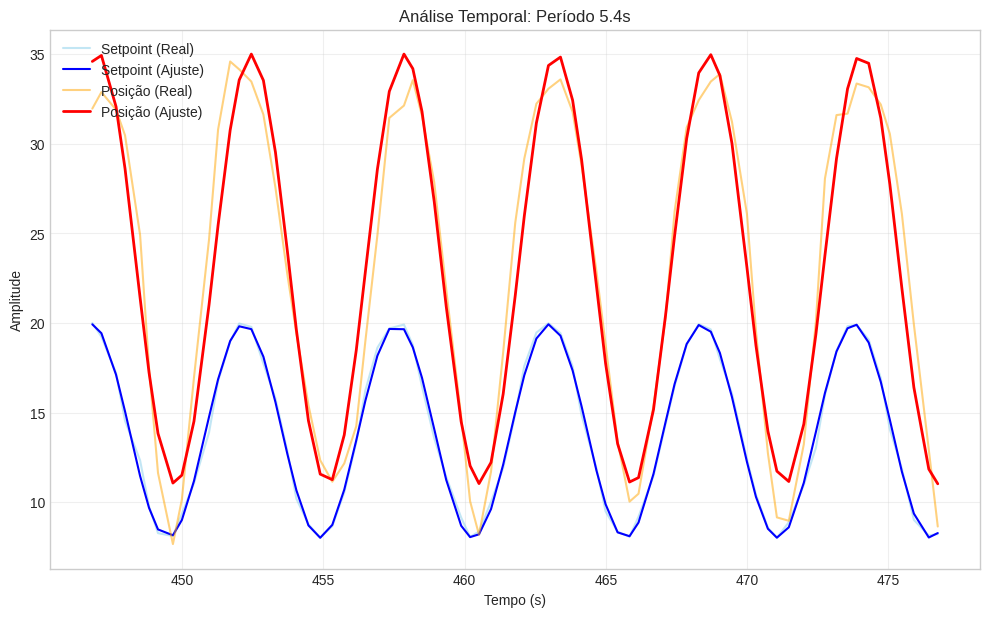

In [10]:
analisar_resposta_temporal(df_global)

---

<br>
<br>
<br>

## Funcionalidade 2: Gerador de Diagrama de Bode
Execute a célula abaixo para processar todos os períodos e gerar os gráficos de Magnitude e Fase.

<br>
<br>
<br>

---

Analisando últimos 30s de cada frequência...

[DESCARTADO] T=4.8s (0.21Hz) | R²=0.44 | Mag=1.4dB | Fase=-18.3°
[DESCARTADO] T=5.0s (0.20Hz) | R²=0.70 | Mag=3.7dB | Fase=-14.5°
[OK] T=5.2s (0.19Hz) | R²=0.87 | Mag=5.2dB | Fase=-13.8°
[OK] T=5.4s (0.19Hz) | R²=0.94 | Mag=6.1dB | Fase=-17.2°
[DESCARTADO] T=5.6s (0.18Hz) | R²=0.05 | Mag=19.2dB | Fase=73.2°
[DESCARTADO] T=5.8s (0.17Hz) | R²=0.79 | Mag=4.4dB | Fase=-13.6°
[DESCARTADO] T=6.0s (0.17Hz) | R²=0.76 | Mag=3.5dB | Fase=-16.1°
[DESCARTADO] T=6.2s (0.16Hz) | R²=0.79 | Mag=2.6dB | Fase=-11.4°
[DESCARTADO] T=6.4s (0.16Hz) | R²=0.78 | Mag=2.1dB | Fase=-11.2°
[DESCARTADO] T=6.6s (0.15Hz) | R²=0.71 | Mag=1.3dB | Fase=-13.4°
[OK] T=6.8s (0.15Hz) | R²=0.90 | Mag=1.9dB | Fase=-14.2°
[DESCARTADO] T=7.0s (0.14Hz) | R²=0.76 | Mag=0.9dB | Fase=-17.0°
[OK] T=7.2s (0.14Hz) | R²=0.85 | Mag=1.5dB | Fase=-16.3°
[OK] T=7.4s (0.14Hz) | R²=0.86 | Mag=1.6dB | Fase=-12.7°
[OK] T=7.6s (0.13Hz) | R²=0.90 | Mag=1.7dB | Fase=-13.6°
[OK] T=7.8s (0.13Hz) | R²=0

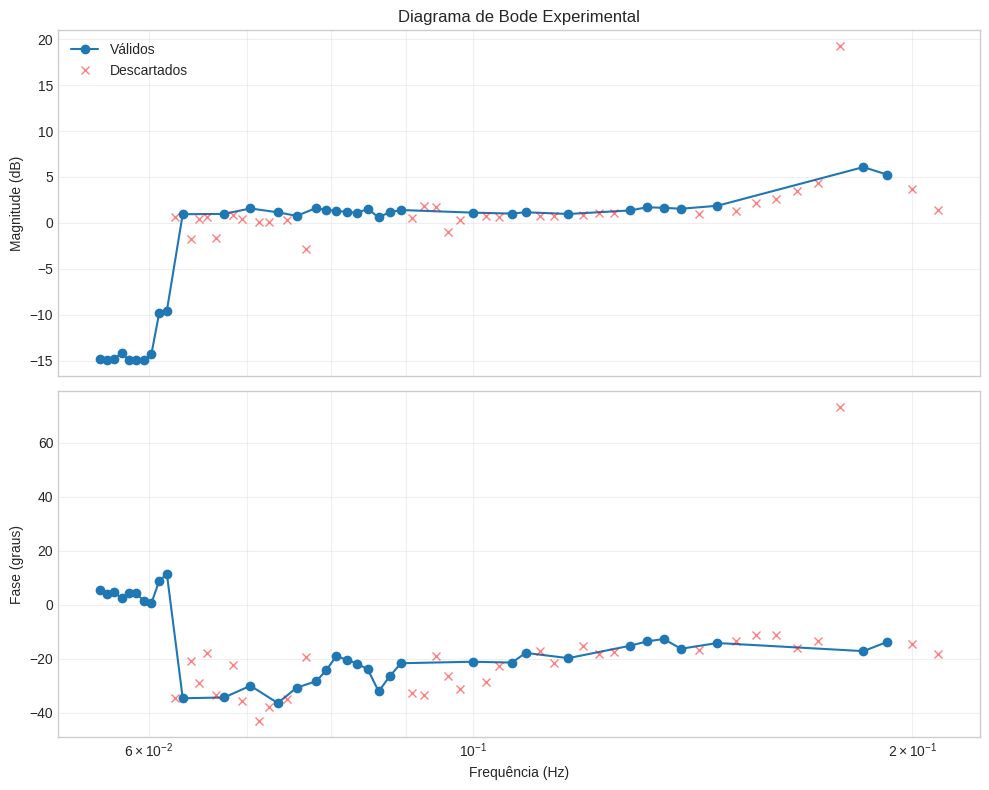

In [11]:
gerar_bode(df_global)